# Medical Insurance Regression Modeling

I want to get some experience seeing different functionality TensorFlow offers. This project is the first step into a larger dataset for regression analysis. The purpose of this is to build out what an actual regression deep learning project might look like using actual data. To dig into this, this notebook uses the medical cost dataset from Kaggle.

* https://www.kaggle.com/datasets/mirichoi0218/insurance?r

This implements regression based neural networks, and included dedicated experiments for exploring different functionalities that TensorFlow has to offer in designing experiments.

The purpose behind the dataset is to predict the insurance cast based off client health information.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model

## Setup, Analyze, & Preprocess Data

Need to look at the data to see what needs to be done to build out a model.

### Setting Up Data

In [95]:
# Reading the dataset from the raw csv file on the public github file
csv_dataset_url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
insurance = pd.read_csv(csv_dataset_url)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Analyzing Dataset

In [96]:
# Looking at the spread of the number of children
insurance['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

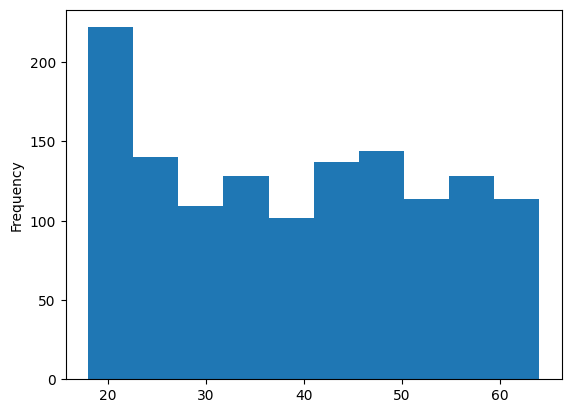

In [97]:
insurance['age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

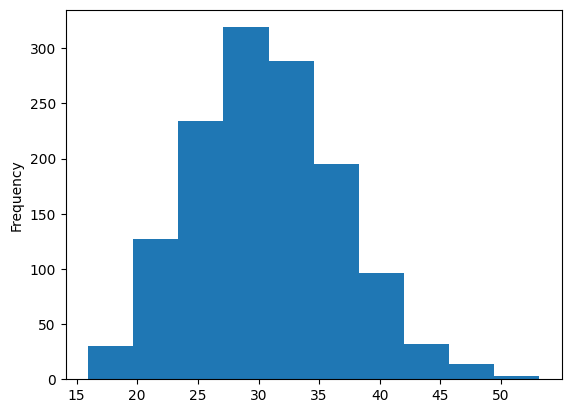

In [98]:
insurance['bmi'].plot(kind='hist')

In [3]:
# Looking at the unique values in the age column
np.unique(insurance['age'].to_numpy())

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

### Preprocess Data

Normalize and encode data.

In [5]:
# Creating the Feature Scaler and One Hot Encoder
column_transformer = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),  # normalize all value in these columns between 0 and 1
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region']))

### Split Train & Test Data

In [6]:
# Separating out the X and y
y_column_name = 'charges'
X_df = insurance.drop(y_column_name, axis=1)
y_df = insurance[y_column_name]

In [7]:
# Splitting the data to test and train
# NOTE: We do not need to convert these to tensors, Pandas is built on top of numpy which is handled directly
# with the model

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Fit the column transformer to our training data
column_transformer.fit(X_train)
X_train_normal = column_transformer.transform(X_train)
X_test_normal = column_transformer.transform(X_test)

X_train_normal[0].shape, y_train[0].shape

((11,), ())

## Experiments

The purpose of these experiments is to predict the insurance cost based off information for the specific client. To do this, I will perform the following experiments.

* Experiment-0 (Baseline): Simple Dense Model
* Experiment-1: Simple Dense Model w/ More Epochs
* Experiment-2: Simple Dense w/ More Epochs & Adam Optimizer
* Experiment-3: Learning Rate Analysis
* Experiment-4 (Exploration): EarlyStopping Callback
* Experiment-5 (Exploration): LambdaCallback
* Experiment-6: Three Hidden Layers w/ Weight Decay
* Experiment-7 (Experimental): Cosine Decay Learning Rate Scheduler
* Experiment-8: Larger Batch Size
* Experiment-9: Deep & Wide Model

### Constants

Standarding specific details used across experiments.

In [8]:
INPUT_SHAPE = 11
OUTPUT_SHAPE = 1

RANDOM_SEED = 42

### Experiment-0 (Baseline): Simple Dense Model

1. Hidden Layer of 100
2. SGD - learning rate = 0.01
3. 25 epochs

In [9]:
# Constants
model_0_name = 'model_0_simple'

LEARNING_RATE = 0.01
EPOCHS_0 = 25

In [10]:
# Setting seed to compare results
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE)
], name=model_0_name)

# Compile Model
model_0.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=LEARNING_RATE),
                metrics=['mae'])

# 3. Fit Model
model_0_history = model_0.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_0,
                              validation_data=(X_test_normal, y_test),
                              verbose=0)

model_0.summary()

2023-09-11 15:55:29.136909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-11 15:55:29.136931: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-11 15:55:29.136936: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-11 15:55:29.136969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-11 15:55:29.136983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-11 15:55:29.393865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 15:55:29.682799:

Model: "model_0_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1301 (5.08 KB)
Trainable params: 1301 (5.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


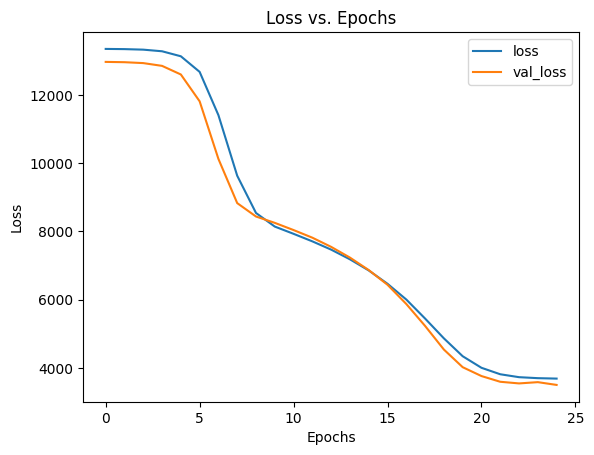

In [11]:
# Viewing History
ml_toolbox.analysis.history.plot_history(model_0_history, 'loss')

9/9 [==============================] - 0s 2ms/step


2023-09-11 15:55:33.259291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


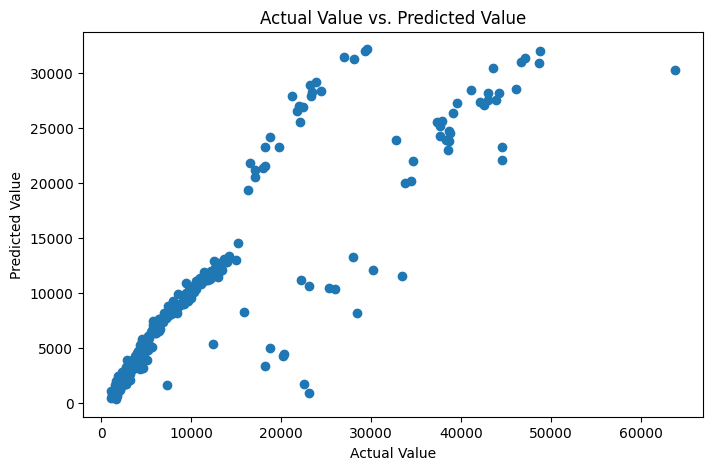

In [12]:
# Predictions
model_0_preds = model_0.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_0_preds, figsize=(8,5))

In [85]:
model_0_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_0_preds, tf.float32),
                                                                             name=model_0_name)
model_0_results

RegressionPredictionMetrics(mae=11059.964, mse=235515740.0, rmse=15152.647, mape=153.54086, mase=0.895658, huber=3499.4458, name='model_0_simple')

### Experiment-1: Simple Model w/ More Epochs

1. Hidden Layer of 100
2. SGD - learning rate = 0.01
3. 75 epochs

In [14]:
# Constants
model_1_name = 'model_1_simple_more_epochs'

LEARNING_RATE = 0.01
EPOCHS_1 = 75

In [15]:
# Random Seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_1 = tf.keras.models.clone_model(model_0)
model_1._name = model_1_name

model_1.summary()

Model: "model_1_simple_more_epochs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1301 (5.08 KB)
Trainable params: 1301 (5.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Compile Model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=LEARNING_RATE),
                metrics=['mae'])

# Fit Model
model_1_history = model_1.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_1,
                              validation_data=(X_test_normal, y_test),
                              verbose=0)

2023-09-11 15:55:33.634741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 15:55:33.865937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


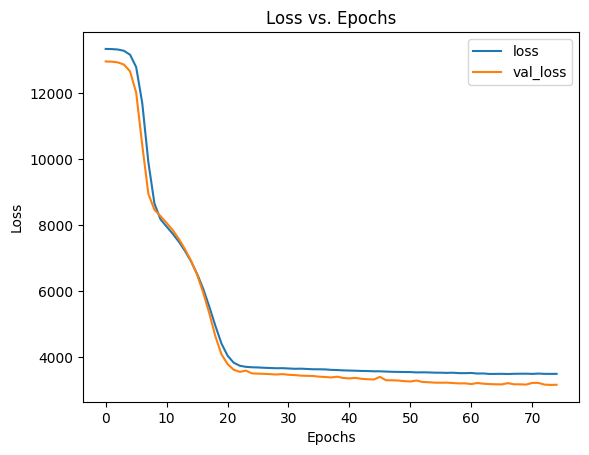

In [17]:
# Viewing History
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')

9/9 [==============================] - 0s 2ms/step


2023-09-11 15:55:44.578315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


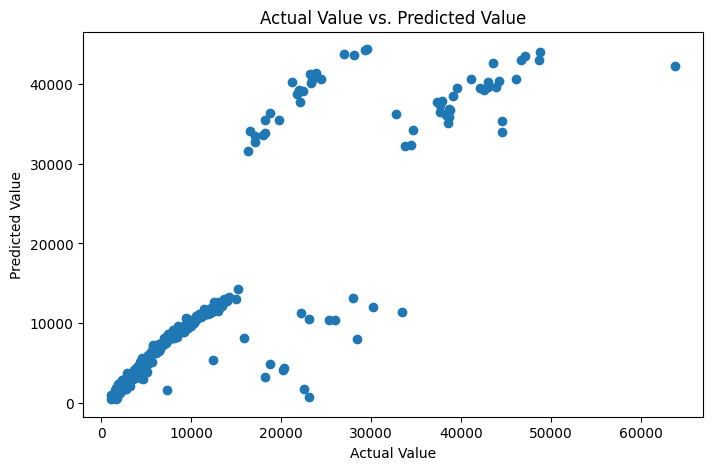

In [18]:
# Predictions
model_1_preds = model_1.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_1_preds, figsize=(8,5))

In [74]:
model_1_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_1_preds, tf.float32),
                                                                             name=model_1_name)
model_1_results

RegressionPredictionMetrics(mae=12967.2295, mse=331412130.0, rmse=17200.518, mape=196.15639, mase=1.0501121, huber=3156.5608, name='model_1_simple_more_epochs')

### Experiment-2: Simple Model w/ More Epochs & Adam Optimizer

1. Hidden Layer of 100
2. Adam - learning rate = 0.01
3. 75 epochs

In [20]:
# Constants
model_2_name = 'model_2_simple_adam'

LEARNING_RATE = 0.01
EPOCHS_2 = 75

In [21]:
# Random Seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_2_name)

# Compile Model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                metrics=['mae', 'mse'])

# Fit Model
model_2_history = model_2.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_2,
                              validation_data=(X_test_normal, y_test),
                              verbose=0)

model_2.summary()

2023-09-11 15:55:44.949280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 15:55:45.256871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "model_2_simple_adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               1200      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1301 (5.08 KB)
Trainable params: 1301 (5.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


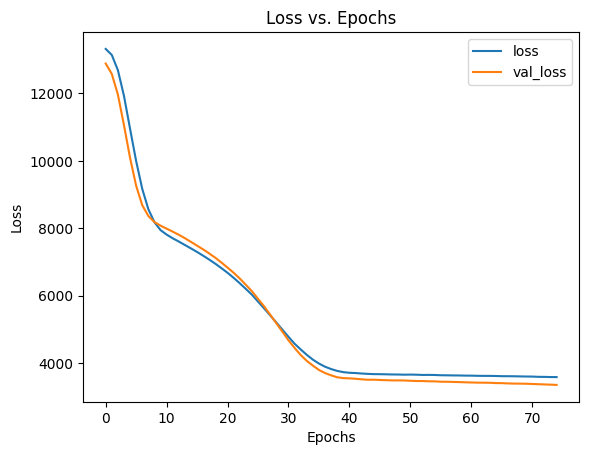

In [22]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')

9/9 [==============================] - 0s 2ms/step


2023-09-11 15:55:58.435158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


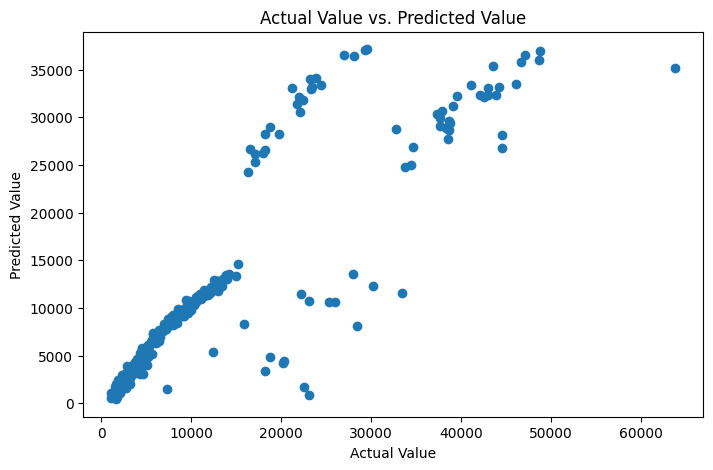

In [23]:
# Predictions
model_2_preds = model_2.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_2_preds, figsize=(8,5))

In [75]:
model_2_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_2_preds, tf.float32),
                                                                             name=model_2_name)
model_2_results

RegressionPredictionMetrics(mae=11802.83, mse=266839500.0, rmse=15913.548, mape=171.63832, mase=0.9558167, huber=3353.8936, name='model_2_simple_adam')

### Experiment-3: Learning Rate Analysis

1. Hidden Layer of 100
2. Adam - variable learning rate
3. 90 epochs

The purpose of this experiment is to explore the optimal learning rate through running a learning rate analysis using a learning rate scheduler.

* https://arxiv.org/pdf/1506.01186.pdf
* https://ai.stackexchange.com/questions/26502/is-there-an-ideal-range-of-learning-rate-which-always-gives-a-good-result-almost

In [25]:
# Constants
model_3_name = 'model_3_variable_learning_rates'

EPOCHS_3 = 90
INITIAL_LEARNING_RATE = 0.001

In [26]:
# Setting seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_3_name)

# Compile Model
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=INITIAL_LEARNING_RATE),
                metrics=['mae'])

# Learning Rate Scheduler
lr_scheduler_callback = ml_toolbox.modeling.learning_rate.generate_exponential_decay_function(
    initial_learning_rate=INITIAL_LEARNING_RATE, decay_factor=2)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_callback)

# Fit Model
model_3_history = model_3.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_3,
                              validation_data=(X_test_normal, y_test),
                              verbose=0,
                              callbacks=[lr_scheduler])

model_3.summary()

2023-09-11 15:55:58.800196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 15:55:59.056181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "model_3_variable_learning_rates"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1200      
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1301 (5.08 KB)
Trainable params: 1301 (5.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


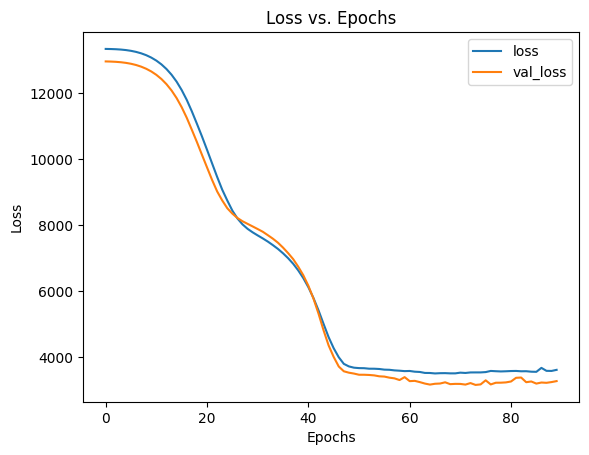

In [27]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')

9/9 [==============================] - 0s 2ms/step


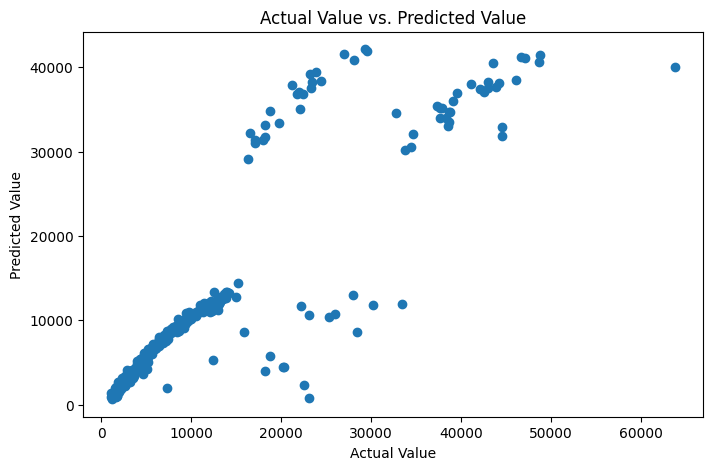

In [32]:
# Predictions
model_3_preds = model_3.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_3_preds, figsize=(8, 5))

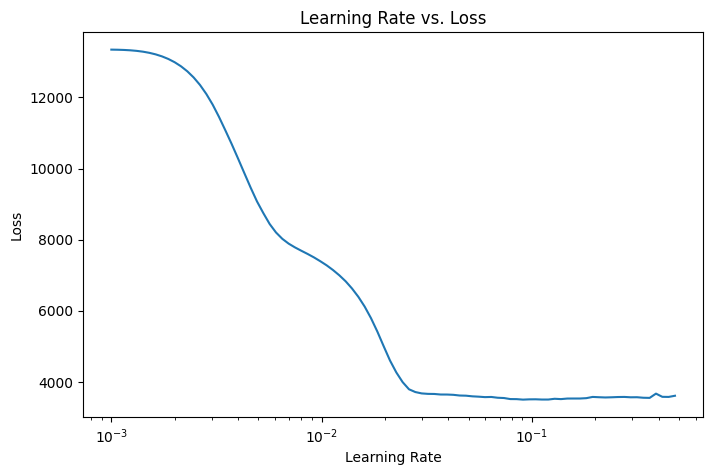

In [31]:
learning_rates = [lr_scheduler_callback(epoch) for epoch in range(EPOCHS_3)]
ml_toolbox.analysis.history.plot_learning_rate_versus_loss(learning_rates,
                                                           model_3_history.history['loss'],
                                                           figsize=(8, 5))

In [76]:
model_3_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_3_preds, tf.float32),
                                                                             name=model_3_name)
model_3_results

RegressionPredictionMetrics(mae=12505.625, mse=305895740.0, rmse=16683.111, mape=189.2575, mase=1.0127305, huber=3268.6804, name='model_3_variable_learning_rates')

#### Findings

After analyzing the learning rate vs. loss plot, the optimal learning rate falls between .02-.05.

### Experiment-4 (Exploration): EarlyStopping Callback

The EarlyStopping callback stops fitting the model once the validation loss stops improving given a designated `patience` (how many epochs to wait without the validation loss decreasing before fitting stops).

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

**NOTE** This section is for personal exploration and does not touch on specific experiments.

To get a better understanding on what TensorFlow offers, I want to get some experience working with the various types of callbacks available.

In [33]:
# Constants
model_4_name = 'model_4_early_stopping_callback'

INITIAL_LEARNING_RATE_EARLY_STOPPING = 0.06
EPOCHS_4 = 200

# Callback Constants
PATIENCE = 20
STARTING_EPOCH = 10

In [35]:
# Setting seed
tf.random.set_seed(42)

# Build Model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_4_name)

# Compile Model
model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=INITIAL_LEARNING_RATE_EARLY_STOPPING),
                metrics=['mae'])

# EarlyStopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PATIENCE,
    start_from_epoch=STARTING_EPOCH,
    restore_best_weights=True)

# Fit Model
model_4_history = model_4.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_4,
                              validation_data=(X_test_normal, y_test),
                              verbose=0,
                              callbacks=[early_stopping])

2023-09-11 16:51:28.544780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 16:51:28.926602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


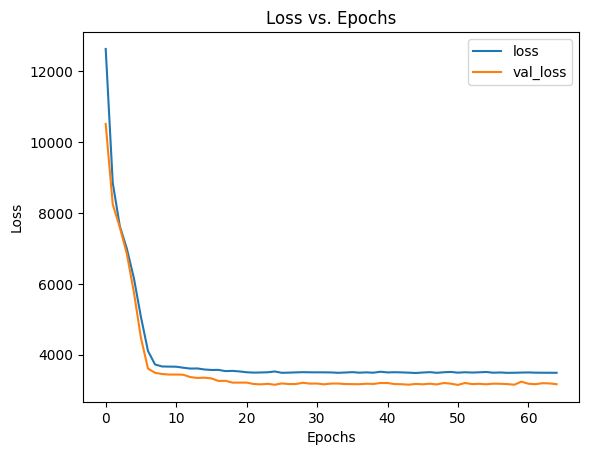

In [44]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')

### Experiment-5 (Exploration): LambdaCallback

The LambdaCallback callback is used to utilize custom callback functions.

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback

**NOTE** This section is for personal exploration and does not touch on specific experiments.

To get a better understanding on what TensorFlow offers, I want to get some experience working with the various types of callbacks available.

In [45]:
# Constants
model_5_name = 'model_5_lambda_callback'

LEARNING_RATE_OPTIMIZED = 0.06
EPOCHS_5 = 10

In [46]:
# Setting seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_5_name)

# Compile Model
model_5.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE_OPTIMIZED),
                metrics=['mae'])

# Lambda Callback
epoch_logger_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f'Epoch Start: {epoch}'),
    on_epoch_end=lambda epoch, logs: print(f'Epoch End: {epoch}', logs))

# Fit Model
model_5_history = model_5.fit(X_train_normal,
                              y_train,
                              epochs=EPOCHS_5,
                              validation_data=(X_test_normal, y_test),
                              callbacks=[epoch_logger_callback],
                              verbose=0)

Epoch Start: 0


2023-09-11 18:02:14.850054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 18:02:15.127389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch End: 0 {'loss': 12631.3994140625, 'mae': 12631.3994140625, 'val_loss': 10509.9697265625, 'val_mae': 10509.9697265625}
Epoch Start: 1
Epoch End: 1 {'loss': 8849.900390625, 'mae': 8849.900390625, 'val_loss': 8242.5615234375, 'val_mae': 8242.5615234375}
Epoch Start: 2
Epoch End: 2 {'loss': 7632.11083984375, 'mae': 7632.11083984375, 'val_loss': 7598.544921875, 'val_mae': 7598.544921875}
Epoch Start: 3
Epoch End: 3 {'loss': 6992.8388671875, 'mae': 6992.8388671875, 'val_loss': 6849.427734375, 'val_mae': 6849.427734375}
Epoch Start: 4
Epoch End: 4 {'loss': 6163.79248046875, 'mae': 6163.79248046875, 'val_loss': 5769.42431640625, 'val_mae': 5769.42431640625}
Epoch Start: 5
Epoch End: 5 {'loss': 5066.517578125, 'mae': 5066.517578125, 'val_loss': 4460.2021484375, 'val_mae': 4460.2021484375}
Epoch Start: 6
Epoch End: 6 {'loss': 4107.697265625, 'mae': 4107.697265625, 'val_loss': 3615.153564453125, 'val_mae': 3615.153564453125}
Epoch Start: 7
Epoch End: 7 {'loss': 3720.981201171875, 'mae': 372

### Experiment-6: Three Hidden Layers w/ Weight Decay

The purpose of this experiment is to view how multiple hidden layers with a weight decay introduced in the Optimizer affect the performance of the model.

1. Three Hidden Layers - (200, 200, 100)
2. Adam - learning_rate=0.06, weight_decay=0.001
3. 40 epochs

In [49]:
# Constants
model_6_name = 'model_6_three_hidden'

EPOCHS_6 = 40
LEARNING_RATE_OPTIMIZED = 0.06
WEIGHT_DECAY = 0.001

In [52]:
# Setting seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_6_name)

# Compile Model
model_6.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_OPTIMIZED, weight_decay=WEIGHT_DECAY),
                metrics=['mae'])

# Fit Model
model_6_history = model_6.fit(
    X_train_normal,
    y_train,
    epochs=EPOCHS_6,
    validation_data=(X_test_normal, y_test),
    verbose=0)

2023-09-11 18:23:54.331195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 18:23:54.781527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


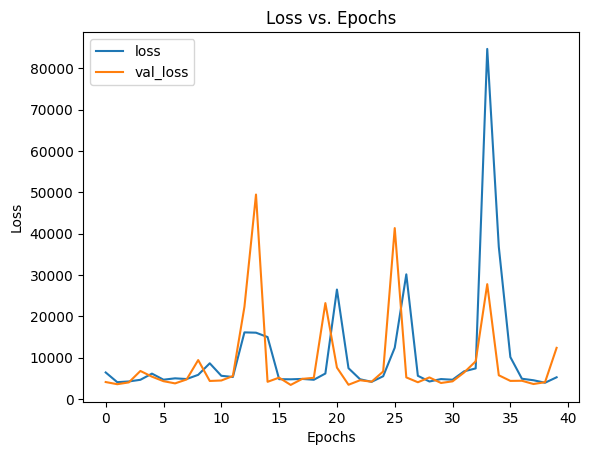

In [53]:
ml_toolbox.analysis.history.plot_history(model_6_history, 'loss')

9/9 [==============================] - 0s 3ms/step


2023-09-11 18:27:11.015994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


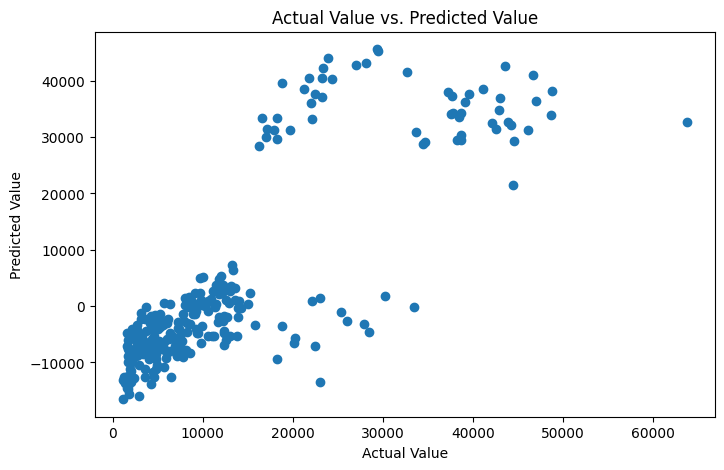

In [54]:
# Predictions
model_6_preds = model_6.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_6_preds, figsize=(8, 5))

In [83]:
model_6_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_6_preds, tf.float32),
                                                                             name=model_6_name)
model_6_results

RegressionPredictionMetrics(mae=19055.467, mse=530963870.0, rmse=22644.48, mape=260.20065, mase=1.5431496, huber=12377.012, name='model_6_three_hidden')

### Experiment-7 (Experimental): CosineDecay Learning Rate Scheduler

The CosineDecay scheduler is used to decay the learning rate.

* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay

**NOTE** This section is for personal exploration and does not touch on specific experiments.

To get a better understanding on what TensorFlow offers, I want to get some experience working with the various types of schedulers available.

In [58]:
# Constants
model_7_name = 'model_7_cosine_decay_scheduler'

EPOCHS_7 = 40
INITIAL_LEARNING_RATE_COSINE_DECAY = 0.05
DECAY_STEPS = 1450
WEIGHT_DECAY = 0.001

In [61]:
# Setting seed
tf.random.set_seed(42)

# Create Model
model_7 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Dense(200, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(OUTPUT_SHAPE),
], name=model_7_name)

# Compile Model w/ ExponentialDecay
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INITIAL_LEARNING_RATE_COSINE_DECAY,
    decay_steps=DECAY_STEPS)

model_7.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE_COSINE_DECAY,
                                                   weight_decay=WEIGHT_DECAY),
                metrics=['mae'])

# Fit Model
model_7_history = model_7.fit(
    X_train_normal,
    y_train,
    epochs=EPOCHS_7,
    validation_data=(X_test_normal, y_test),
    verbose=0)

2023-09-11 18:53:46.039150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 18:53:46.375166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


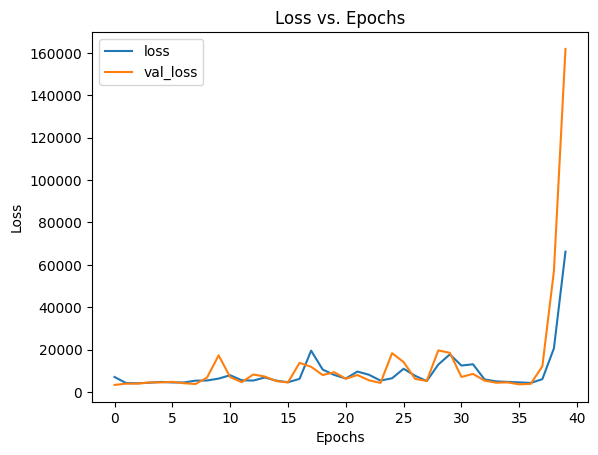

In [62]:
ml_toolbox.analysis.history.plot_history(model_7_history, 'loss')

### Experiment-8: Larger Batch Size

This experiment will attempt a different batch size to see how it affects the performance of the same model built in Experiment-6.

1. Three Hidden Layers - (200, 200, 100)
2. Adam - learning_rate=0.06, weight_decay=0.001
3. 40 epochs
4. Batch Size - 64

In [64]:
# Constants
model_8_name = 'model_8_large_batch'

EPOCHS_8 = 40
BATCH_SIZE = 64
LEARNING_RATE_OPTIMIZED = 0.06
WEIGHT_DECAY = 0.001

In [67]:
# Setting seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
model_8 = tf.keras.models.clone_model(model_6)
model_8._name = model_8_name

# Compile Model
model_8.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_OPTIMIZED, weight_decay=WEIGHT_DECAY),
                metrics=['mae'])

# Fit Model
model_8_history = model_8.fit(
    X_train_normal,
    y_train,
    epochs=EPOCHS_8,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_normal, y_test),
    verbose=0)

2023-09-11 19:10:20.072332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 19:10:20.331631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


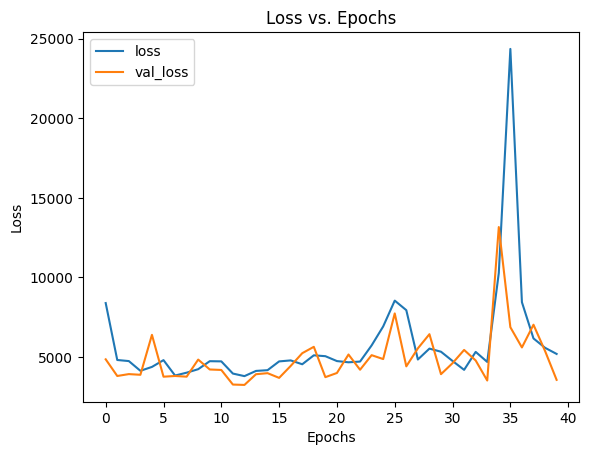

In [68]:
ml_toolbox.analysis.history.plot_history(model_8_history, 'loss')

9/9 [==============================] - 0s 3ms/step


2023-09-11 19:40:27.677188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


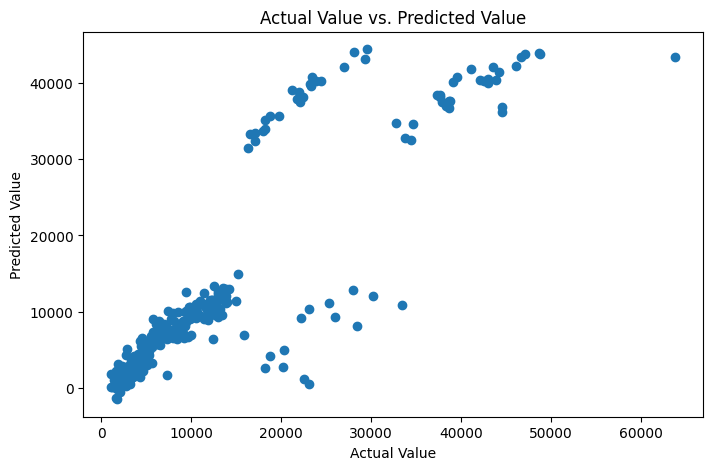

In [78]:
# Predictions
model_8_preds = model_8.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_8_preds, figsize=(8, 5))

In [82]:
model_8_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_8_preds, tf.float32),
                                                                             name=model_8_name)
model_8_results

RegressionPredictionMetrics(mae=13153.22, mse=339922560.0, rmse=17444.518, mape=195.44029, mase=1.0651739, huber=3554.908, name='model_8_large_batch')

### Experiment-9: Deep & Wide Model

Neural Networks can be linked across layers and concatenated to get a wide network at the same time as a deep neural network. This allows for fitting little data that can be relatively simple to model. Below, I will test out adding a linear only, quadratic only, and non-linear connections to determine the output.

Note:
1. Wide Neural Networks are typically less layers and more neurons.
2. Deep Neural Networks are more layers and less neurons.

In [70]:
# Constants
model_9_name = 'model_9_deep_and_wide'

EPOCHS_9 = 40
LEARNING_RATE_OPTIMIZED = 0.06
WEIGHT_DECAY = 0.001

In [71]:
# Setting seed
tf.random.set_seed(RANDOM_SEED)

# Build Model
input_layer = tf.keras.layers.Input(shape=(INPUT_SHAPE,))

# Making Non-linear HiddenLayer Tree of Layers
hidden_layer_1 = tf.keras.layers.Dense(200)(input_layer)
hidden_layer_2 = tf.keras.layers.Dense(200, activation='relu')(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Dense(100)(hidden_layer_2)

# Making Linear Link Tree of Layers
hidden_layer_linear_1 = tf.keras.layers.Dense(300)(input_layer)

# Making Quadratic Link Tree of Layers
hidden_layer_quadratic_1 = tf.keras.layers.Dense(300, activation=lambda x: x**2)(input_layer)

# Concatenating Wide Layers and Making Output Layer
concatenation_layer = tf.keras.layers.Concatenate()([
    hidden_layer_3,
    hidden_layer_linear_1,
    hidden_layer_quadratic_1,
])

output_layer = tf.keras.layers.Dense(OUTPUT_SHAPE)(concatenation_layer)

model_9 = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# Compile Model w/ ExponentialDecay
model_9.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_OPTIMIZED,
                                                   weight_decay=WEIGHT_DECAY),
                metrics=['mae'])

# Fit Model
model_9_history = model_9.fit(
    X_train_normal,
    y_train,
    epochs=EPOCHS_9,
    validation_data=(X_test_normal, y_test),
    verbose=0)

2023-09-11 19:34:28.595023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 19:34:29.070379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


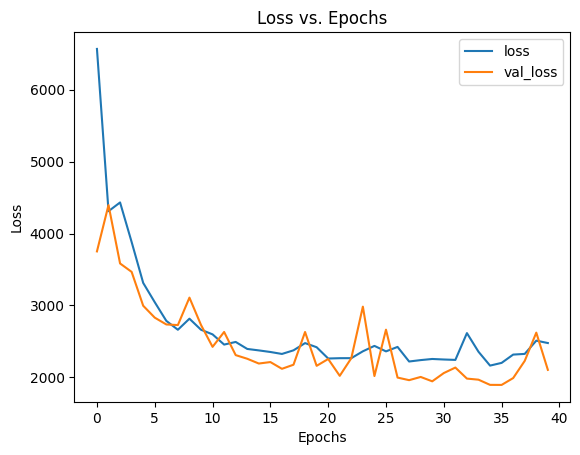

In [72]:
ml_toolbox.analysis.history.plot_history(model_9_history, 'loss')

9/9 [==============================] - 0s 4ms/step


2023-09-11 19:40:47.228052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


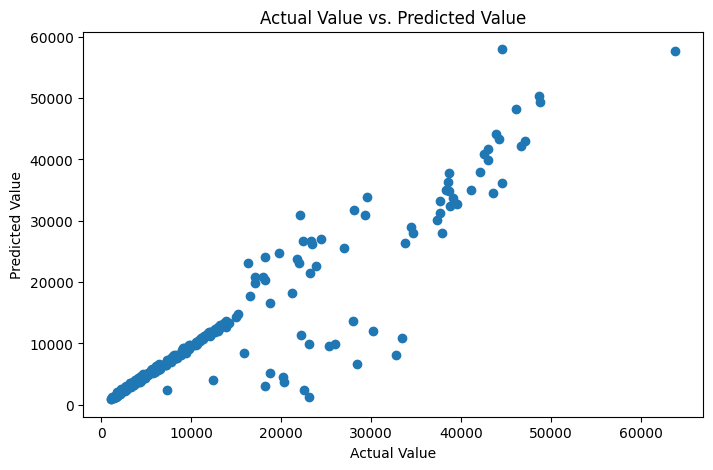

In [80]:
# Predictions
model_9_preds = model_9.predict(X_test_normal)

ml_toolbox.analysis.regression.plot_true_versus_predicted(y_test, model_9_preds, figsize=(8, 5))

In [84]:
model_9_results = ml_toolbox.analysis.regression.generate_prediction_metrics(tf.cast(y_test, tf.float32),
                                                                             tf.cast(model_9_preds, tf.float32),
                                                                             name=model_9_name)
model_9_results

RegressionPredictionMetrics(mae=12010.513, mse=292717340.0, rmse=16266.425, mape=170.15732, mase=0.97263527, huber=2104.0989, name='model_9_deep_and_wide')

## Analysis

After running the experiments, I am going to analyze the non-experimental experiments performance metrics to compare the difference between the various types of models.

In [86]:
model_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_6_results,
    model_8_results,
    model_9_results,
]
model_results

[RegressionPredictionMetrics(mae=11059.964, mse=235515740.0, rmse=15152.647, mape=153.54086, mase=0.895658, huber=3499.4458, name='model_0_simple'),
 RegressionPredictionMetrics(mae=12967.2295, mse=331412130.0, rmse=17200.518, mape=196.15639, mase=1.0501121, huber=3156.5608, name='model_1_simple_more_epochs'),
 RegressionPredictionMetrics(mae=11802.83, mse=266839500.0, rmse=15913.548, mape=171.63832, mase=0.9558167, huber=3353.8936, name='model_2_simple_adam'),
 RegressionPredictionMetrics(mae=12505.625, mse=305895740.0, rmse=16683.111, mape=189.2575, mase=1.0127305, huber=3268.6804, name='model_3_variable_learning_rates'),
 RegressionPredictionMetrics(mae=19055.467, mse=530963870.0, rmse=22644.48, mape=260.20065, mase=1.5431496, huber=12377.012, name='model_6_three_hidden'),
 RegressionPredictionMetrics(mae=13153.22, mse=339922560.0, rmse=17444.518, mape=195.44029, mase=1.0651739, huber=3554.908, name='model_8_large_batch'),
 RegressionPredictionMetrics(mae=12010.513, mse=292717340.0,

In [87]:
model_results_df = ml_toolbox.analysis.regression.generate_prediction_metrics_dataframe(model_results)
model_results_df

,mae,mse,rmse,mape,mase,huber
model_0_simple,11059.963867,235515744.0,15152.647461,153.540863,0.895658,3499.445801
model_1_simple_more_epochs,12967.229492,331412128.0,17200.517578,196.156387,1.050112,3156.560791
model_2_simple_adam,11802.830078,266839504.0,15913.547852,171.638321,0.955817,3353.893555
model_3_variable_learning_rates,12505.625000,305895744.0,16683.111328,189.257507,1.012730,3268.680420
model_6_three_hidden,19055.466797,530963872.0,22644.480469,260.200653,1.543150,12377.011719
model_8_large_batch,13153.219727,339922560.0,17444.517578,195.440292,1.065174,3554.907959
model_9_deep_and_wide,12010.512695,292717344.0,16266.424805,170.157318,0.972635,2104.098877


<Axes: >

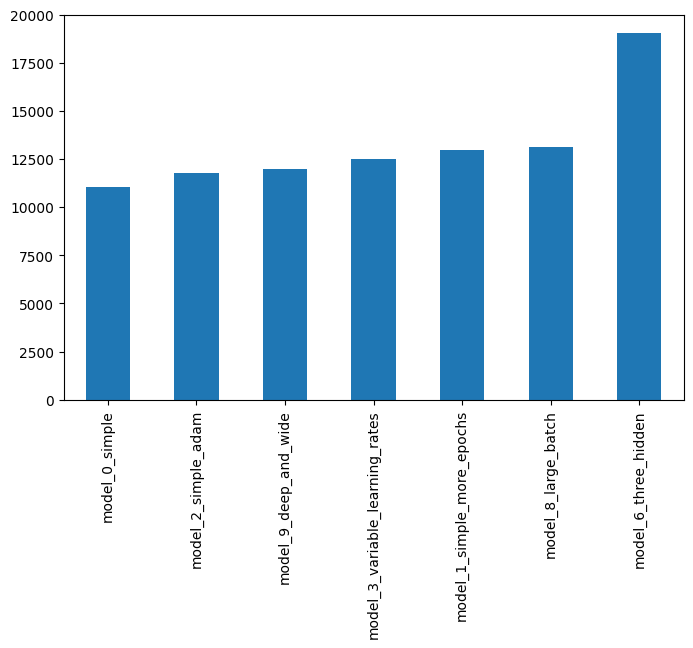

In [93]:
model_results_df['mae'].sort_values().plot(figsize=(8, 5), kind='bar')